### Device

In [1]:
import torch
import numpy as np

print(torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.get_device_name(0))
device = torch.device('cuda')
print(device)

True True NVIDIA GeForce GTX 1650 with Max-Q Design
cuda


### Tensor practice

In [2]:
# TENSOR 1: cpu, gpu, numpy/list
T1 = torch.Tensor( np.array([[1,2,3],[4,5,6]]) ) # or torch.Tensor( [[1,2,3],[4,5,6]] )
print(T1, T1.device, "\n", sep=", ")

T2 = torch.Tensor([[1,2,3],[4,5,6]]).to(device)
T2.requires_grad = True # trainable
print(T2, T2.device, "\n", sep=", ")

T3 = T2.cpu().detach().numpy()
print(T3) # must convert to cpu and non-trainable before covert to numpy/list # or T2.cpu().detach().tolist()

tensor([[1., 2., 3.],
        [4., 5., 6.]]), cpu, 

tensor([[1., 2., 3.],
        [4., 5., 6.]], device='cuda:0', requires_grad=True), cuda:0, 

[[1. 2. 3.]
 [4. 5. 6.]]


In [3]:
# TENSOR 2: calculation
T = torch.Tensor([[1,2,3],[4,5,6]])
print(T, type(T), T[0], T[0][0], T.size(), T.shape, T.dtype, "\n")

print(T+T, "\n", T-T, "\n", T*T, "\n", T/T, "\n")

tensor([[1., 2., 3.],
        [4., 5., 6.]]) <class 'torch.Tensor'> tensor([1., 2., 3.]) tensor(1.) torch.Size([2, 3]) torch.Size([2, 3]) torch.float32 

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]]) 
 tensor([[0., 0., 0.],
        [0., 0., 0.]]) 
 tensor([[ 1.,  4.,  9.],
        [16., 25., 36.]]) 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 



In [4]:
# Tensor 3: built-in tensor
print( torch.zeros((2,4), dtype=torch.int32) )
print( torch.ones((2,4), dtype=torch.float64, device=device) )
print( torch.rand(2, 3, device=device) )

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)
tensor([[0.0132, 0.4989, 0.8701],
        [0.9422, 0.8103, 0.1461]], device='cuda:0')


### Dataset
+ map-style dataset: has the \_\_getitem\_\_ and \_\_len\_\_
+ iterable-style dataset: has \_\_iter\_\_ protocol
+ Both of them doesn't occupy memory. Map-style dataset is recommended
+ Example: dog cat classification. Each class contains 12500 images with different size <br>
https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip

In [5]:
import glob, random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2

class MyDataset(Dataset):
    def __init__(self, pathList, device):
        self.pathList = pathList
        self.device = device
    def __len__(self):
        return len(self.pathList)
    def __getitem__(self, index):
        x = cv2.imread( self.pathList[index] )
        x = cv2.resize(x, (224,224))
        x = np.moveaxis(x, -1, 0)
        x = torch.Tensor(x).to(device)
        y = torch.Tensor([1,0]).to(self.device) if "dog" in self.pathList[index] else torch.Tensor([0,1]).to(self.device)
        return x,y

pathList = glob.glob("train/*")
random.shuffle(pathList)
trainPathList, valPathList = pathList[:int(len(pathList)*0.8)], pathList[int(len(pathList)*0.8):]
trainDataset, valDataset = MyDataset(trainPathList,device), MyDataset(valPathList,device)
print( len(trainDataset), len(valDataset) )

20000 5000


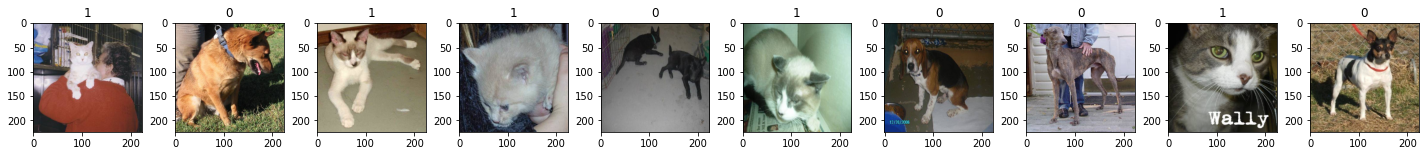

In [6]:
plt.figure(figsize=(25,2))
for i,(X,y) in enumerate(trainDataset):
    if i<10:
        XLast = np.moveaxis(X.cpu().numpy().astype(int), 0, -1)
        plt.subplot(1,10,i+1)
        plt.imshow(XLast[:,:,::-1])
        plt.title( int(y.argmax()) )
    else:
        break
plt.show()

In [7]:
import math
batch_size = 16
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, pin_memory=False)
valDataLoader   = DataLoader(valDataset, batch_size=batch_size, pin_memory=False)
stepPerEpoch = math.ceil(len(trainDataset)/batch_size)

### Neural network

In [8]:
import time
from torch import nn

class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1   = nn.ReLU()
        self.maxpool1= nn.MaxPool2d(2)
        self.conv2   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2   = nn.ReLU()
        self.maxpool2= nn.MaxPool2d(2)
        self.conv3   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3   = nn.ReLU()
        self.maxpool3= nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dense1  = nn.Linear(28*28*64, 64)
        self.dense2  = nn.Linear(64, 64)
        self.dense3  = nn.Linear(64, 2)
        self.softmax = nn.Softmax(dim=1) # axis=1 # batch axis:0
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        #x = self.softmax(x)
        return x

model = myModel().to(device)
# get total paramters
print( sum( parameter.numel() for parameter in model.parameters() ) ) # type: torch.nn.parameter.Parameter
# get weights for a layer
for parameter in model.conv1.parameters(): # or for name,param in model.named_parameters():
    print(parameter.shape) # set non-trainable: parameter.requires_grad = False
# inference time test
T = torch.Tensor( np.random.random((1,3,224,224)) ).to(device)
s = time.time()
pred = model(T)
print( time.time()-s, pred )

3291266
torch.Size([64, 3, 3, 3])
torch.Size([64])
0.03423762321472168 tensor([[-0.1363,  0.0284]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

def training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history):
    trainDataNum = len(trainDataLoader)*trainDataLoader.batch_size
    valDataNum = len(valDataLoader)*valDataLoader.batch_size
    for ep in range(epochs):
        print(f"Epoch: {ep+1}/{epochs}")
        
        # training loop
        trainLoss, trainAcc = 0.0, 0.0
        for i,(X,y) in enumerate(trainDataLoader):
            # loss
            optimizer.zero_grad()    # zero the parameter gradients
            pred = model(X)          # forward + backward + optimize
            loss = loss_func(pred,y) # (1,) tensor
            loss.backward()
            optimizer.step()
            trainLoss += loss.item() / trainDataNum
            # acc
            ypred = pred.argmax(axis=1)
            ytrue = y.argmax(axis=1)
            trainAcc += int((ypred==ytrue).sum()) / trainDataNum
            #
            print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}, trainAcc={trainAcc:.5f}", end="")
        history["trainLossL"].append(trainLoss)
        history["trainAccL"].append(trainAcc)
        print()

        # validation loop
        with torch.no_grad():
            valLoss, valAcc = 0.0, 0.0
            for i,(X,y) in enumerate(valDataLoader):
                # loss
                pred = model(X)
                loss = loss_func(pred,y)
                valLoss += loss.item() / valDataNum
                # acc
                ypred = pred.argmax(axis=1)
                ytrue = y.argmax(axis=1)
                valAcc += int((ypred==ytrue).sum()) / valDataNum
                #
                print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}, valAcc={valAcc:.5f}", end="")
            history["valLossL"].append(valLoss)
            history["valAccL"].append(valAcc)
            print()
    return history

history = {"trainLossL":[], "trainAccL":[], "valLossL":[], "valAccL":[]}

In [10]:
epochs = 1
history = training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history)

Epoch: 1/1
batch=1250/1250, trainLoss=0.04294, trainAcc=0.67440
batch=313/313, valLoss=0.03338, valAcc=0.73263


In [11]:
epochs = 1
history = training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history)

Epoch: 1/1
batch=1250/1250, trainLoss=0.03034, trainAcc=0.76525
batch=313/313, valLoss=0.03053, valAcc=0.76418


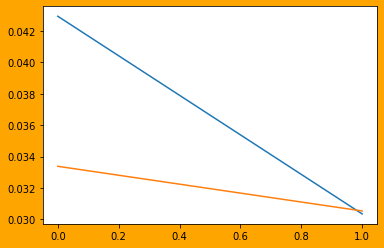

In [12]:
ax = plt.figure()
ax.set_facecolor("orange")
plt.plot(history["trainLossL"])
plt.plot(history["valLossL"])
plt.show()

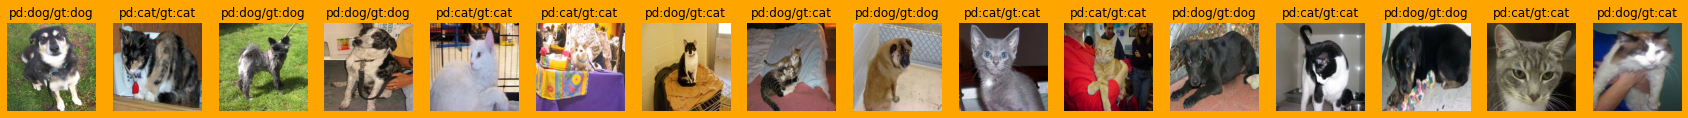

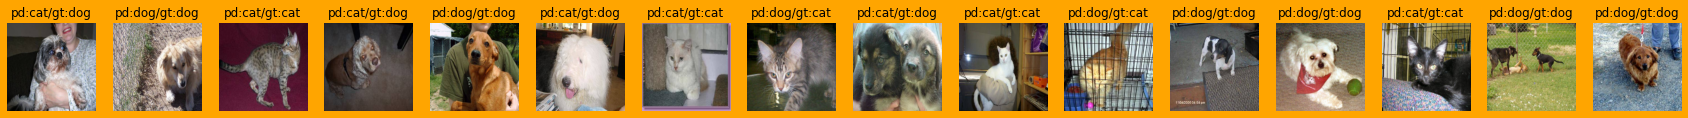

In [13]:
with torch.no_grad():
    for i,(X,y) in enumerate(valDataLoader):
        if i<2:
            pred = model(X)
            ypred = pred.argmax(axis=1)
            ytrue = y.argmax(axis=1)
            XLast = np.moveaxis(X.cpu().numpy().astype(int), 1, -1) # (bz,224,224,3)
            ax = plt.figure(figsize=(30,2*3))
            ax.set_facecolor("orange")
            for j in range(valDataLoader.batch_size):
                plt.subplot(1,valDataLoader.batch_size,j+1)
                plt.title(f"pd:{'dog' if ypred[j]==0 else 'cat'}/gt:{'dog' if ytrue[j]==0 else 'cat'}")
                plt.imshow( XLast[j,:,:,::-1] )
                plt.axis('off')
            plt.show()
        else:
            break

### Save/Load model

In [14]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([64, 3, 3, 3])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 64, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([64, 64, 3, 3])
conv3.bias 	 torch.Size([64])
dense1.weight 	 torch.Size([64, 50176])
dense1.bias 	 torch.Size([64])
dense2.weight 	 torch.Size([64, 64])
dense2.bias 	 torch.Size([64])
dense3.weight 	 torch.Size([2, 64])
dense3.bias 	 torch.Size([2])


In [15]:
T = torch.rand(1,3,224,224,device=device)
model(T)

tensor([[-0.2235,  0.1384]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
### weight
# save
torch.save(model.state_dict(), "model_state_dict.pt")
# load
model = myModel().to(device)
model.load_state_dict(torch.load("model_state_dict.pt"))
# predict
model(T)

tensor([[-0.2235,  0.1384]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
### entire model

In [18]:
# save
torch.save(model, "model.pth")
# load
model = torch.load("model.pth")
# predict
model(T)

tensor([[-0.2235,  0.1384]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
# transfer learning
epochs = 1
history = training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history)

Epoch: 1/1
batch=1250/1250, trainLoss=0.02505, trainAcc=0.82250
batch=313/313, valLoss=0.03053, valAcc=0.76418
